## TF-IDF Model - Baseline Information Retrieval System
##### **Proyek:** Sistem Temu Kembali Informasi Konsultasi Kesehatan  
##### **Nama:** Daffa Afaf Firmansyah  
##### **NIM:** A11.2022.14166  
##### **Model:** TF-IDF + Cosine Similarity (Baseline)

### Tujuan:
##### 1. Membangun baseline IR system menggunakan TF-IDF
##### 2. Implement search function dengan cosine similarity
##### 3. Evaluasi performa dengan metrik IR (Precision, Recall, MAP)
##### 4. Visualisasi hasil dan analisis
##### 5. Save model untuk production use

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import time
from pathlib import Path
from tqdm import tqdm

# Scikit-learn for TF-IDF and metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# Text preprocessing 
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
data_path = Path('../data/processed/processed_full.csv')
print(f"Loading: {data_path}")

df = pd.read_csv(data_path)

print(f"\n Data loaded successfully!")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display sample
print("\n Sample Data:")
print(df[['title', 'processed_question', 'topic_set']].head(3))

Loading: ..\data\processed\processed_full.csv

 Data loaded successfully!
Shape: 360,513 rows × 20 columns
Memory: 2190.99 MB

 Sample Data:
                                              title  \
0                        Khasiat obat zinc sulphate   
1                      Perbedaan jenis formula zinc   
2  Mengkonsumsi suplemen zinc yang sudah kadaluarsa   

                                                                                                                                                                                        processed_question  \
0  khasiat obat zinc sulphate dok mau tanya anak kan nak fimosis terus kasih obat zincpro zinc sulphate drops 10mg ml kata buat vitamin lancar bak la terus tak baca kok malah obat buat anak diare dok...   
1  beda jenis formula zinc siang dokter dokter sayang tanya beda khasiat sehat tubuh manusia beda zinc sulphate zinc lactate apa masing masing manfaat efek samping dua mineral sebut konsumsi lebih ut...   
2                   

In [3]:
# Check for missing processed text
missing_processed = df['processed_question'].isna().sum()
print(f"Missing processed questions: {missing_processed}")

if missing_processed > 0:
    print("Removing rows with missing processed text...")
    df = df.dropna(subset=['processed_question'])

# Ensure processed text is string type
df['processed_question'] = df['processed_question'].astype(str)
df['processed_answer'] = df['processed_answer'].astype(str)

# Create document corpus (what we'll search in)
documents = df['processed_question'].tolist()

print(f"\n Document corpus prepared")
print(f"Total documents: {len(documents):,}")
print(f"\n Sample document:")
print(f"{documents[0][:200]}...")

Missing processed questions: 0

 Document corpus prepared
Total documents: 360,513

 Sample document:
khasiat obat zinc sulphate dok mau tanya anak kan nak fimosis terus kasih obat zincpro zinc sulphate drops 10mg ml kata buat vitamin lancar bak la terus tak baca kok malah obat buat anak diare dok pda...


In [4]:
# Gunakan gabungan title + processed_question (sudah di-stem) tanpa cleaning agresif tambahan
print("Menyusun dokumen gabungan: title + processed_question ...")

df['title'] = df['title'].astype(str).fillna('')
df['doc_text'] = (df['title'].fillna('') + ' ' + df['processed_question'].fillna('')).str.strip()

# Corpus
documents = df['doc_text'].tolist()

print(f"Total documents: {len(documents):,}")
print("Sample document (gabungan):")
print(documents[0][:200])
print("\n✅ Dokumen adalah gabungan title + processed_question; tidak ada pembersihan tambahan")

Menyusun dokumen gabungan: title + processed_question ...
Total documents: 360,513
Sample document (gabungan):
Khasiat obat zinc sulphate khasiat obat zinc sulphate dok mau tanya anak kan nak fimosis terus kasih obat zincpro zinc sulphate drops 10mg ml kata buat vitamin lancar bak la terus tak baca kok malah o

✅ Dokumen adalah gabungan title + processed_question; tidak ada pembersihan tambahan


### TF-IDF Vectorization 
#### **TF-IDF (Term Frequency - Inverse Document Frequency)**
#### - **TF**: How often a term appears in a document
#### - **IDF**: How rare/common a term is across all documents
#### - **TF-IDF**: Balances frequency with uniqueness

In [5]:
# SIMPLE TF-IDF: Data sudah di-stem dari preprocessing.ipynb
print("\nInitializing TF-IDF (data sudah pre-stemmed)...")

tfidf_vectorizer = TfidfVectorizer(
    max_features=30000,
    min_df=2,                       # lebih longgar agar lebih banyak token masuk
    max_df=0.90,                    # biarkan istilah agak umum tetap masuk
    ngram_range=(1, 2),             # Unigrams + bigrams
    sublinear_tf=True,
    norm='l2',
    lowercase=True,
    token_pattern=r'(?u)\b\w+\b'    # Simple word tokenization
)

print("Fitting TF-IDF on cleaned corpus...")
start_time = time.time()

tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

elapsed_time = time.time() - start_time

print(f"\n✅ TF-IDF completed in {elapsed_time:.2f} seconds")
print(f"\n TF-IDF Matrix:")
print(f"   Shape: {tfidf_matrix.shape}")
print(f"   Vocabulary size: {tfidf_matrix.shape[1]:,}")
print(f"   Sparsity: {(1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))*100:.2f}%")
print(f"   Memory: {tfidf_matrix.data.nbytes / 1024**2:.2f} MB")

# Check vocabulary quality
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\n First 50 vocabulary terms:")
for i, term in enumerate(feature_names[:50], 1):
    print(f"{i:2d}. {term}", end="   ")
    if i % 5 == 0:
        print()

# Check medical terms
medical_terms = ['demam', 'tinggi', 'anak', 'sakit', 'batuk', 'hamil', 'ibu', 'obat']
print(f"\n Medical Terms Check:")
found = 0
for term in medical_terms:
    if term in feature_names:
        found += 1
        term_idx = np.where(feature_names == term)[0][0]
        doc_count = (tfidf_matrix[:, term_idx] > 0).sum()
        doc_pct = doc_count / tfidf_matrix.shape[0] * 100
        print(f"  ✅ '{term}': {doc_count} docs ({doc_pct:.1f}%)")
    else:
        print(f"  ❌ '{term}': NOT IN VOCAB")

print(f"\n Found {found}/{len(medical_terms)} medical terms")


Initializing TF-IDF (data sudah pre-stemmed)...
Fitting TF-IDF on cleaned corpus...

✅ TF-IDF completed in 35.18 seconds

 TF-IDF Matrix:
   Shape: (360513, 30000)
   Vocabulary size: 30,000
   Sparsity: 99.81%
   Memory: 156.37 MB

 First 50 vocabulary terms:
 1. 0    2. 00    3. 00 wib    4. 000    5. 01   
 6. 02    7. 03    8. 04    9. 05   10. 06   
11. 07   12. 08   13. 09   14. 0px   15. 0px 0px   
16. 0px 20px   17. 0px font   18. 0px padding   19. 0px vertical   20. 1   
21. 1 5   22. 1 bulan   23. 1 hari   24. 1 minggu   25. 1 tahun   
26. 10   27. 10 11   28. 10 15   29. 10 bln   30. 10 bulan   
31. 10 hari   32. 10 hr   33. 10 jam   34. 10 kali   35. 10 kg   
36. 10 malam   37. 10 menit   38. 10 mg   39. 10 minggu   40. 10 pagi   
41. 10 tahun   42. 10 thn   43. 100   44. 100 70   45. 100 mg   
46. 1000   47. 1000mg   48. 100mg   49. 10bln   50. 10bulan   

 Medical Terms Check:
  ✅ 'demam': 19166 docs (5.3%)
  ✅ 'tinggi': 12459 docs (3.5%)
  ✅ 'anak': 37099 docs (10.3%)
 


 Top 20 Most Discriminative Terms (Highest IDF):
 1. false name           IDF: 12.0035
 2. false unhidewhenused IDF: 12.0035
 3. semihidden false     IDF: 12.0035
 4. unhidewhenused false IDF: 12.0035
 5. accent               IDF: 11.8494
 6. accent u0026gt       IDF: 11.8494
 7. colorful             IDF: 11.8494
 8. false priority       IDF: 11.8494
 9. grid                 IDF: 11.8494
10. grid accent          IDF: 11.8494
11. list accent          IDF: 11.8494
12. locked               IDF: 11.8494
13. locked false         IDF: 11.8494
14. lsdexception         IDF: 11.8494
15. lsdexception locked  IDF: 11.8494
16. medium grid          IDF: 11.8494
17. name colorful        IDF: 11.8494
18. name light           IDF: 11.8494
19. name medium          IDF: 11.8494
20. priority             IDF: 11.8494

 Top 20 Most Common Terms (Lowest IDF):
 1. dok                  IDF: 1.1354
 2. tanya                IDF: 1.8410
 3. apa                  IDF: 1.8660
 4. mau                  IDF: 1.8879
 

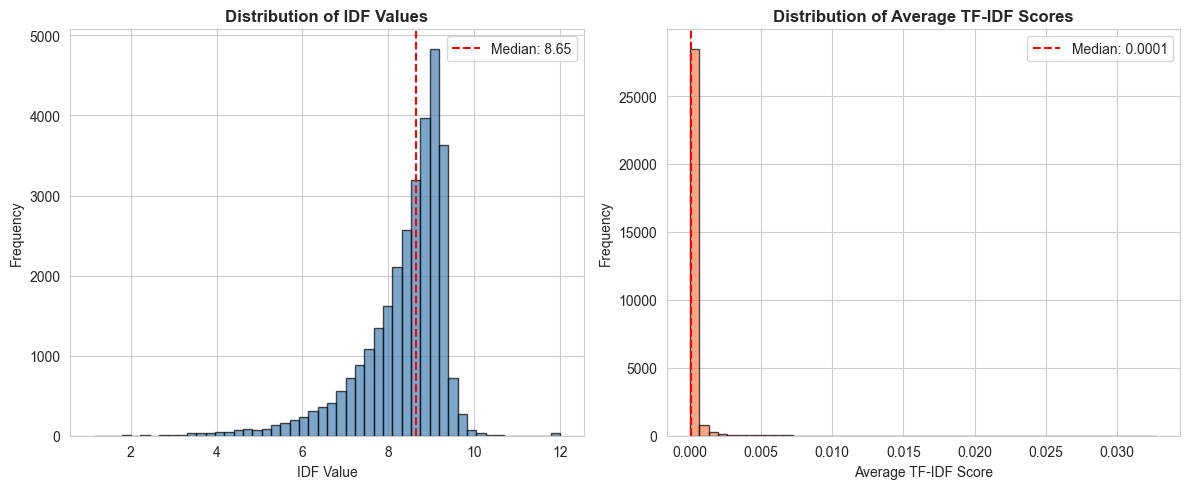

In [6]:
# Get IDF values for all terms
idf_values = tfidf_vectorizer.idf_
idf_dict = dict(zip(feature_names, idf_values))

# Sort by IDF (highest = most discriminative/rare terms)
sorted_idf = sorted(idf_dict.items(), key=lambda x: x[1], reverse=True)

print("\n Top 20 Most Discriminative Terms (Highest IDF):")
print("="*70)
for i, (term, idf) in enumerate(sorted_idf[:20], 1):
    print(f"{i:2d}. {term:20s} IDF: {idf:.4f}")

print("\n Top 20 Most Common Terms (Lowest IDF):")
print("="*70)
for i, (term, idf) in enumerate(sorted(idf_dict.items(), key=lambda x: x[1])[:20], 1):
    print(f"{i:2d}. {term:20s} IDF: {idf:.4f}")

# Visualize IDF distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(idf_values, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('IDF Value')
plt.ylabel('Frequency')
plt.title('Distribution of IDF Values', fontweight='bold')
plt.axvline(np.median(idf_values), color='red', linestyle='--', 
            label=f'Median: {np.median(idf_values):.2f}')
plt.legend()

plt.subplot(1, 2, 2)
# Get average TF-IDF score per term
avg_tfidf_per_term = np.array(tfidf_matrix.mean(axis=0)).flatten()
plt.hist(avg_tfidf_per_term, bins=50, color='coral', edgecolor='black', alpha=0.7)
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Frequency')
plt.title('Distribution of Average TF-IDF Scores', fontweight='bold')
plt.axvline(np.median(avg_tfidf_per_term), color='red', linestyle='--',
            label=f'Median: {np.median(avg_tfidf_per_term):.4f}')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# Initialize preprocessors
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()
stopword_factory = StopWordRemoverFactory()
stopwords = stopword_factory.get_stop_words()

def preprocess_query(query):
    """
    Query preprocessing – samakan pipeline dengan dokumen (dokumen sudah stemmed)
    Langkah: lower → bersihkan URL/email/punctuation → token → stopword removal → stemming
    """
    if pd.isna(query) or query == "":
        return ""
    
    text = str(query).lower()
    
    # Remove URLs, emails, mentions, hashtags
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove HTML/CSS artifacts
    text = re.sub(r'\d+px', '', text)
    text = re.sub(r'padding|margin|font|vertical|align', '', text)
    
    # Remove tokens with digits & standalone numbers
    text = re.sub(r'\b\w*\d+\w*\b', ' ', text)
    text = re.sub(r'\b\d+\b', '', text)
    
    # Remove time patterns
    text = re.sub(r'\d{1,2}:\d{2}', '', text)
    text = re.sub(r'wib|wit|wita', '', text, flags=re.IGNORECASE)
    
    # Remove punctuation and extra spaces
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize
    tokens = text.split()
    
    # Filter: length > 1, no digits
    tokens = [t for t in tokens if len(t) > 1 and not any(c.isdigit() for c in t)]
    
    # Remove stopwords
    tokens = [t for t in tokens if t not in stopwords]
    
    # Stemming agar selaras dengan dokumen yang sudah di-stem
    tokens = [stemmer.stem(t) for t in tokens]
    
    return ' '.join(tokens)

# Test preprocessing
print("Testing query preprocessing (dengan stemming)...")
test_queries = [
    "anak saya demam tinggi dan batuk",
    "bagaimana cara mengatasi asam lambung?",
    "Ibu hamil boleh minum obat apa ya dok",
    "anak 2 tahun demam 39 derajat"
 ]

print("\n Query Preprocessing Examples:")
print("="*70)
for i, query in enumerate(test_queries, 1):
    processed = preprocess_query(query)
    print(f"\n{i}. Original:  {query}")
    print(f"   Processed: {processed}")

print("\n ✅ Query preprocessing ready (term-stemmed)")

Testing query preprocessing (dengan stemming)...

 Query Preprocessing Examples:

1. Original:  anak saya demam tinggi dan batuk
   Processed: anak demam tinggi batuk

2. Original:  bagaimana cara mengatasi asam lambung?
   Processed: bagaimana cara atas asam lambung

3. Original:  Ibu hamil boleh minum obat apa ya dok
   Processed: ibu hamil minum obat apa dok

4. Original:  anak 2 tahun demam 39 derajat
   Processed: anak tahun demam derajat

 ✅ Query preprocessing ready (term-stemmed)


In [8]:
def search_tfidf(query, top_k=10, return_scores=True, preprocessed=False):
    """
    Search for relevant documents using TF-IDF + Cosine Similarity
    
    Parameters:
    -----------
    query : str
        User query text (raw or already preprocessed)
    top_k : int
        Number of top results to return
    return_scores : bool
        Whether to return similarity scores
    preprocessed : bool
        If True, assume query is already cleaned/stemmed and skip preprocessing
    
    Returns:
    --------
    results : pd.DataFrame
        Top-k most similar documents with metadata
    """
    
    # Step 1: Preprocess query unless already preprocessed
    processed_query = query if preprocessed else preprocess_query(query)
    
    if not processed_query:
        print(" Query preprocessing resulted in empty text")
        return pd.DataFrame()
    
    # Step 2: Transform query to TF-IDF vector
    query_vector = tfidf_vectorizer.transform([processed_query])
    
    # Step 3: Calculate cosine similarity with all documents
    similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
    
    # Step 4: Get top-k indices
    top_k_indices = similarities.argsort()[-top_k:][::-1]
    
    # Step 5: Get top-k scores
    top_k_scores = similarities[top_k_indices]
    
    # Step 6: Create results dataframe
    results = df.iloc[top_k_indices].copy()
    results['similarity_score'] = top_k_scores
    results['rank'] = range(1, len(results) + 1)
    
    # Reorder columns for better readability
    result_columns = ['rank', 'similarity_score', 'title', 'answer', 
                      'topic_set', 'answer_count', 'year']
    
    # Only include columns that exist
    result_columns = [col for col in result_columns if col in results.columns]
    
    return results[result_columns]

print("Search function implemented!")

Search function implemented!


In [9]:
# Test queries
test_queries = [
    "anak demam tinggi",
    "sakit kepala dan mual",
    "cara mengatasi asam lambung",
    "ibu hamil minum obat",
    "batuk berdahak tidak sembuh"
]

for i, query in enumerate(test_queries, 1):
    print(f"\n{'='*70}")
    print(f"TEST QUERY {i}: {query}")
    print(f"{'='*70}")
    
    # Search
    results = search_tfidf(query, top_k=5)
    
    if results.empty:
        print("No results found!")
        continue
    
    # Display results
    print(f"\n Top 5 Results:")
    for idx, row in results.iterrows():
        print(f"\n{row['rank']}. [Score: {row['similarity_score']:.4f}] {row['title'][:80]}")
        print(f"   Topic: {row['topic_set']}")
        print(f"   Answer: {row['answer'][:150]}...")


TEST QUERY 1: anak demam tinggi

 Top 5 Results:

1. [Score: 0.5690] Demam tinggi pada anak
   Topic: demam-pada-anak
   Answer: Waalaikumsalam,Demam merupakan suatu gejala yang muncul saat sistem kekebalan tubuh sedang berperang melawan infeksi. Seseorang dikatakan demam jika s...

2. [Score: 0.5550] Anak demam bolehkah di suntik
   Topic: infeksi-virus
   Answer: Alo! Terima kasih atas pertanyaannya di Alodokter, Demam  merupakan respon tubuh terhadap berbagai penyebab, yang ditandai dengan meningkatnya suhu tu...

3. [Score: 0.5446] Mengatasi demam tinggi pada bayi
   Topic: demam-pada-anak
   Answer: Halo Mega,Demam pada anak seringkali mengkhawatirkan orang tua, padahal sebagian besar penyebab demam pada anak adalah tidak berbahaya. Demam pada ana...

4. [Score: 0.5059] Penggunaan selimut saat anak demam tinggi
   Topic: demam
   Answer: Wa alaikumsalam, terima kasih telah bertanya di Alodokter. Demam adalah salah satu mekanisme pertahanan tubuh terhadap infeksi oleh agen penyeba

In [10]:
def precision_at_k(relevant_docs, retrieved_docs, k):
    """
    Calculate Precision@k
    
    Precision@k = (# relevant docs in top-k) / k
    """
    retrieved_at_k = retrieved_docs[:k]
    relevant_retrieved = len(set(retrieved_at_k) & set(relevant_docs))
    return relevant_retrieved / k if k > 0 else 0.0

def recall_at_k(relevant_docs, retrieved_docs, k):
    """
    Calculate Recall@k
    
    Recall@k = (# relevant docs in top-k) / (total # relevant docs)
    """
    if len(relevant_docs) == 0:
        return 0.0
    
    retrieved_at_k = retrieved_docs[:k]
    relevant_retrieved = len(set(retrieved_at_k) & set(relevant_docs))
    return relevant_retrieved / len(relevant_docs)

def average_precision(relevant_docs, retrieved_docs, k=None):
    """
    Calculate Average Precision (AP)
    
    AP = (sum of P@k for each relevant doc) / (total # relevant docs)
    """
    if len(relevant_docs) == 0:
        return 0.0
    
    if k is None:
        k = len(retrieved_docs)
    
    retrieved_at_k = retrieved_docs[:k]
    
    precisions = []
    num_relevant = 0
    
    for i, doc_id in enumerate(retrieved_at_k, 1):
        if doc_id in relevant_docs:
            num_relevant += 1
            precisions.append(num_relevant / i)
    
    if len(precisions) == 0:
        return 0.0
    
    return sum(precisions) / len(relevant_docs)

def mean_average_precision(queries_relevant_docs, queries_retrieved_docs, k=10):
    """
    Calculate Mean Average Precision (MAP@k)
    
    MAP@k = mean of AP@k across all queries
    """
    aps = []
    for relevant, retrieved in zip(queries_relevant_docs, queries_retrieved_docs):
        ap = average_precision(relevant, retrieved, k)
        aps.append(ap)
    
    return np.mean(aps) if aps else 0.0

def ndcg_at_k(relevant_docs, retrieved_docs, k):
    """
    Calculate Normalized Discounted Cumulative Gain (NDCG@k)
    
    Simple version: binary relevance (relevant=1, not relevant=0)
    """
    retrieved_at_k = retrieved_docs[:k]
    relevant_set = set(relevant_docs)

    # DCG: sum of (relevance / log2(rank+1))
    dcg = 0.0
    for i, doc_id in enumerate(retrieved_at_k, 1):
        relevance = 1 if doc_id in relevant_set else 0
        dcg += relevance / np.log2(i + 1)

    # IDCG: ideal DCG with all relevant docs ranked at the top
    m = min(len(relevant_set), k)
    idcg = sum(1 / np.log2(i + 1) for i in range(1, m + 1))

    return dcg / idcg if idcg > 0 else 0.0

print("Evaluation metrics implemented!")
print("\nAvailable metrics:")
print("  • Precision@k")
print("  • Recall@k")
print("  • Average Precision (AP)")
print("  • Mean Average Precision (MAP@k)")
print("  • NDCG@k")

Evaluation metrics implemented!

Available metrics:
  • Precision@k
  • Recall@k
  • Average Precision (AP)
  • Mean Average Precision (MAP@k)
  • NDCG@k


In [11]:
# Strategy: Documents are relevant if they share the same topic_set
# Relevansi deterministik: ambil hingga 30 dokumen paling mirip (cosine TF-IDF) dalam topik, excl. dirinya

test_topics = df['topic_set'].value_counts().head(10).index.tolist()

test_queries_data = []

for topic in test_topics:
    topic_docs = df[df['topic_set'] == topic]

    if len(topic_docs) >= 5:
        query_samples = topic_docs.sample(n=3, random_state=42)

        for idx, query_row in query_samples.iterrows():
            topic_indices = topic_docs.index.tolist()
            topic_tfidf = tfidf_matrix[topic_indices]

            # Vector untuk dokumen query (pakai gabungan doc_text agar konteks penuh)
            query_vec = tfidf_vectorizer.transform([query_row['doc_text']])
            sims = cosine_similarity(query_vec, topic_tfidf).flatten()

            # Urutkan descending, buang dirinya sendiri
            ranked = [(topic_indices[i], s) for i, s in enumerate(sims) if topic_indices[i] != idx]
            ranked = sorted(ranked, key=lambda x: x[1], reverse=True)

            # Ambil top 30 relevan terdekat
            relevant_indices = [r[0] for r in ranked[:30]]

            test_queries_data.append({
                'query': query_row['title'],
                'query_processed': query_row['processed_question'],  # query panjang (pertanyaan penuh)
                'topic': topic,
                'relevant_doc_indices': relevant_indices
            })

print(f"\n Created {len(test_queries_data)} test queries")
if len(test_queries_data) > 0:
    print(f"Average relevant docs per query: {np.mean([len(q['relevant_doc_indices']) for q in test_queries_data]):.1f}")
    print("\n  Relevansi = top-30 terdekat (cosine TF-IDF) dalam topik, excl. diri sendiri")
else:
    print("No queries created; check topic sizes.")


 Created 30 test queries
Average relevant docs per query: 30.0

  Relevansi = top-30 terdekat (cosine TF-IDF) dalam topik, excl. diri sendiri


In [12]:
# Evaluation at different k values
k_values = [5, 10, 20]

results_summary = []

print(f"\nEvaluating {len(test_queries_data)} queries...")

for query_data in tqdm(test_queries_data, desc="Evaluating"):
    # Use processed query text to match the indexed docs; skip preprocessing in search
    query_raw = query_data['query']
    query_text = query_data['query_processed']
    relevant_indices = set(query_data['relevant_doc_indices'])
    
    # Search using the processed query text (preprocessed=True to avoid double cleaning)
    search_results = search_tfidf(query_text, top_k=max(k_values), preprocessed=True)
    
    if search_results.empty:
        continue
    
    # Get retrieved document indices
    retrieved_indices = search_results.index.tolist()

    # Calculate metrics for each k
    for k in k_values:
        retrieved_at_k = retrieved_indices[:k]
        hits_k = len(set(retrieved_at_k) & relevant_indices)
        success_k = 1 if hits_k > 0 else 0
        recall_cap_k = hits_k / min(k, len(relevant_indices)) if len(relevant_indices) > 0 else 0.0

        # RR@k: posisi relevan pertama di top-k
        rr_k = 0.0
        for rank_pos, doc_id in enumerate(retrieved_at_k, 1):
            if doc_id in relevant_indices:
                rr_k = 1.0 / rank_pos
                break

        precision = precision_at_k(relevant_indices, retrieved_indices, k)
        recall = recall_at_k(relevant_indices, retrieved_indices, k)
        ap = average_precision(relevant_indices, retrieved_indices, k)
        ndcg = ndcg_at_k(relevant_indices, retrieved_indices, k)
        
        results_summary.append({
            'query': query_raw[:50],
            'topic': query_data['topic'],
            'k': k,
            'precision': precision,
            'recall': recall,
            'ap': ap,
            'ndcg': ndcg,
            'num_relevant': len(relevant_indices),
            'hits@k': hits_k,
            'success@k': success_k,
            'recall_cap': recall_cap_k,
            'rr@k': rr_k
        })

# Create results dataframe
eval_df = pd.DataFrame(results_summary)

print("\n Evaluation completed!")


Evaluating 30 queries...


Evaluating: 100%|██████████| 30/30 [00:14<00:00,  2.11it/s]


 Evaluation completed!


In [13]:
# Aggregate by k
if eval_df.empty:
    print("⚠️ eval_df kosong; pastikan test_queries_data terisi dan search menghasilkan dokumen.")
else:
    agg_rows = []
    map_rows = []

    for k in k_values:
        k_results = eval_df[eval_df['k'] == k]

        precision_mean = k_results['precision'].mean()
        recall_mean = k_results['recall'].mean()
        ap_mean = k_results['ap'].mean()
        ndcg_mean = k_results['ndcg'].mean()
        hit_rate = k_results['hits@k'].mean()
        success_rate = k_results['success@k'].mean()
        recall_cap_mean = k_results['recall_cap'].mean()
        mrr_mean = k_results['rr@k'].mean()

        agg_rows.append({
            'k': k,
            'precision_mean': precision_mean,
            'precision_std': k_results['precision'].std(),
            'recall_mean': recall_mean,
            'recall_std': k_results['recall'].std(),
            'ap_mean': ap_mean,
            'ap_std': k_results['ap'].std(),
            'ndcg_mean': ndcg_mean,
            'ndcg_std': k_results['ndcg'].std(),
            'hit_rate_mean': hit_rate,
            'success_rate_mean': success_rate,
            'recall_cap_mean': recall_cap_mean,
            'recall_cap_std': k_results['recall_cap'].std(),
            'mrr_mean': mrr_mean
        })

        map_score = ap_mean  # MAP@k = mean AP@k across queries
        map_rows.append({'k': k, 'map': map_score})

        print(f"\n{'='*70}")
        print(f"Results @ k={k}")
        print(f"{'='*70}")
        print(f"Precision@{k}:   {precision_mean:.4f} ± {k_results['precision'].std():.4f}")
        print(f"Recall@{k}:      {recall_mean:.4f} ± {k_results['recall'].std():.4f}")
        print(f"AP@{k}:          {ap_mean:.4f} ± {k_results['ap'].std():.4f}")
        print(f"NDCG@{k}:        {ndcg_mean:.4f} ± {k_results['ndcg'].std():.4f}")
        print(f"Hits@{k}:        {hit_rate:.2f} (avg count)")
        print(f"Success@{k}:     {success_rate:.2f} (prop query dgn >=1 relevan)")
        print(f"RecallCap@{k}:   {recall_cap_mean:.4f} ± {k_results['recall_cap'].std():.4f}")
        print(f"MRR@{k}:         {mrr_mean:.4f}")
        print(f"MAP@{k}:         {map_score:.4f}")

    agg_df = pd.DataFrame(agg_rows)
    map_df = pd.DataFrame(map_rows)

    eval_summary = agg_df.merge(map_df, on='k').sort_values('k')
    numeric_cols = ['precision_mean', 'precision_std', 'recall_mean', 'recall_std', 'ap_mean', 'ap_std', 'ndcg_mean', 'ndcg_std', 'hit_rate_mean', 'success_rate_mean', 'recall_cap_mean', 'recall_cap_std', 'mrr_mean', 'map']
    eval_summary[numeric_cols] = eval_summary[numeric_cols].apply(lambda s: s.round(4))

    print("\nSummary table (dibulatkan 4 desimal):")
    display(eval_summary)

    print("\nMarkdown summary (salin ke laporan jika perlu):")
    print(eval_summary.to_markdown(index=False))


Results @ k=5
Precision@5:   0.2533 ± 0.2675
Recall@5:      0.0422 ± 0.0446
AP@5:          0.0220 ± 0.0275
NDCG@5:        0.2096 ± 0.2226
Hits@5:        1.27 (avg count)
Success@5:     0.57 (prop query dgn >=1 relevan)
RecallCap@5:   0.2533 ± 0.2675
MRR@5:         0.2261
MAP@5:         0.0220

Results @ k=10
Precision@10:   0.2900 ± 0.2695
Recall@10:      0.0967 ± 0.0898
AP@10:          0.0508 ± 0.0628
NDCG@10:        0.2512 ± 0.2371
Hits@10:        2.90 (avg count)
Success@10:     0.77 (prop query dgn >=1 relevan)
RecallCap@10:   0.2900 ± 0.2695
MRR@10:         0.2542
MAP@10:         0.0508

Results @ k=20
Precision@20:   0.2767 ± 0.2318
Recall@20:      0.1844 ± 0.1546
AP@20:          0.0918 ± 0.1107
NDCG@20:        0.2552 ± 0.2195
Hits@20:        5.53 (avg count)
Success@20:     0.87 (prop query dgn >=1 relevan)
RecallCap@20:   0.2767 ± 0.2318
MRR@20:         0.2617
MAP@20:         0.0918

Summary table (dibulatkan 4 desimal):


,k,precision_mean,precision_std,recall_mean,recall_std,ap_mean,ap_std,ndcg_mean,ndcg_std,hit_rate_mean,success_rate_mean,recall_cap_mean,recall_cap_std,mrr_mean,map
0,5,0.2533,0.2675,0.0422,0.0446,0.0220,0.0275,0.2096,0.2226,1.2667,0.5667,0.2533,0.2675,0.2261,0.0220
1,10,0.2900,0.2695,0.0967,0.0898,0.0508,0.0628,0.2512,0.2371,2.9000,0.7667,0.2900,0.2695,0.2542,0.0508
2,20,0.2767,0.2318,0.1844,0.1546,0.0918,0.1107,0.2552,0.2195,5.5333,0.8667,0.2767,0.2318,0.2617,0.0918



Markdown summary (salin ke laporan jika perlu):
|   k |   precision_mean |   precision_std |   recall_mean |   recall_std |   ap_mean |   ap_std |   ndcg_mean |   ndcg_std |   hit_rate_mean |   success_rate_mean |   recall_cap_mean |   recall_cap_std |   mrr_mean |    map |
|----:|-----------------:|----------------:|--------------:|-------------:|----------:|---------:|------------:|-----------:|----------------:|--------------------:|------------------:|-----------------:|-----------:|-------:|
|   5 |           0.2533 |          0.2675 |        0.0422 |       0.0446 |    0.022  |   0.0275 |      0.2096 |     0.2226 |          1.2667 |              0.5667 |            0.2533 |           0.2675 |     0.2261 | 0.022  |
|  10 |           0.29   |          0.2695 |        0.0967 |       0.0898 |    0.0508 |   0.0628 |      0.2512 |     0.2371 |          2.9    |              0.7667 |            0.29   |           0.2695 |     0.2542 | 0.0508 |
|  20 |           0.2767 |          0.2318 

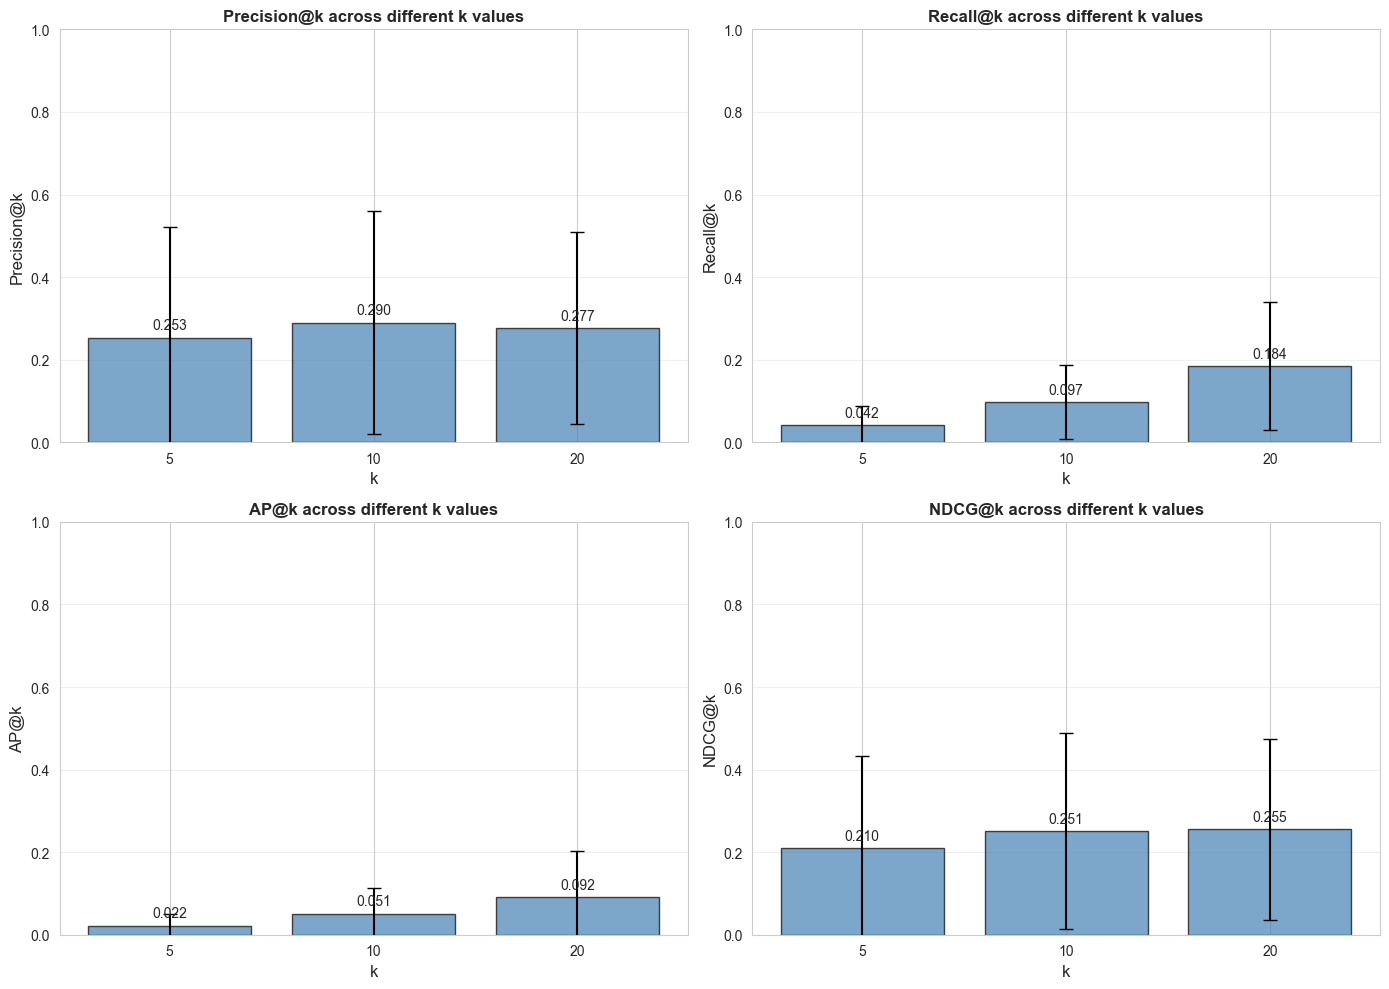

In [14]:
# Plot 1: Metrics comparison across k values
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['precision', 'recall', 'ap', 'ndcg']
metric_names = ['Precision@k', 'Recall@k', 'AP@k', 'NDCG@k']

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx // 2, idx % 2]
    
    # Aggregate by k
    metric_by_k = eval_df.groupby('k')[metric].agg(['mean', 'std']).reset_index()
    
    ax.bar(metric_by_k['k'].astype(str), metric_by_k['mean'], 
           yerr=metric_by_k['std'], capsize=5, color='steelblue', alpha=0.7, edgecolor='black')
    
    ax.set_xlabel('k', fontsize=12)
    ax.set_ylabel(name, fontsize=12)
    ax.set_title(f'{name} across different k values', fontweight='bold')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (k_val, mean_val) in enumerate(zip(metric_by_k['k'], metric_by_k['mean'])):
        ax.text(i, mean_val + 0.02, f'{mean_val:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

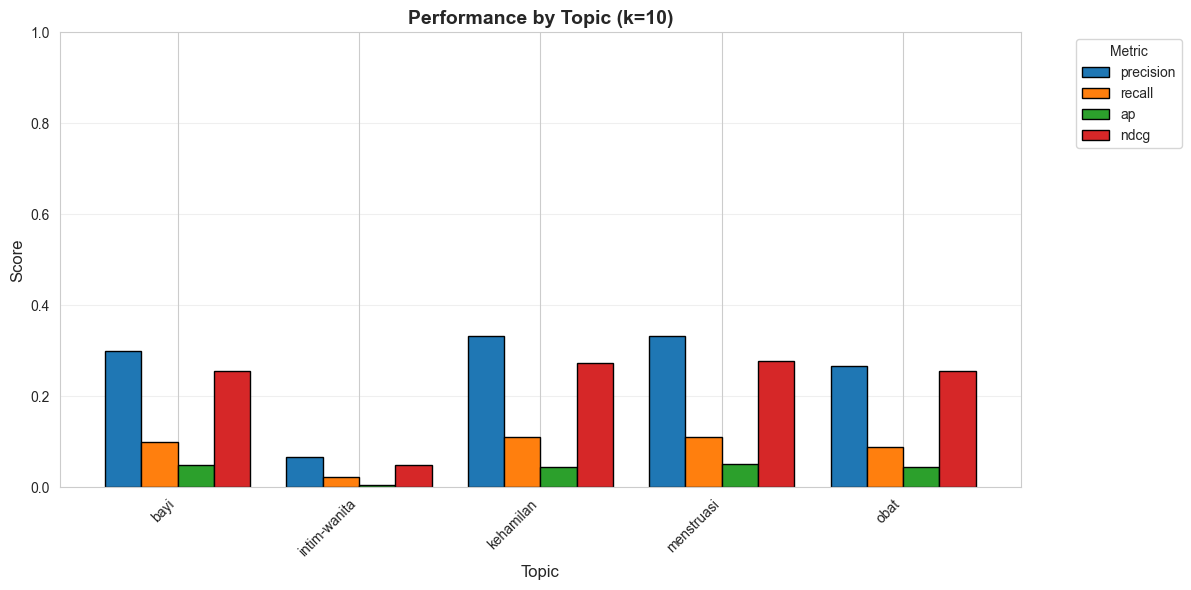

In [15]:
# Top 5 topics by query count
top_topics = eval_df['topic'].value_counts().head(5).index

topic_performance = eval_df[eval_df['topic'].isin(top_topics) & (eval_df['k'] == 10)].groupby('topic')[
    ['precision', 'recall', 'ap', 'ndcg']
].mean()

fig, ax = plt.subplots(figsize=(12, 6))
topic_performance.plot(kind='bar', ax=ax, width=0.8, edgecolor='black')
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performance by Topic (k=10)', fontweight='bold', fontsize=14)
ax.set_ylim([0, 1.0])
ax.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [16]:
# Show best and worst performing queries
k = 10
k_results = eval_df[eval_df['k'] == k].copy()

# Best queries
print("\n Top 5 Best Performing Queries (by AP@10):")
print("="*70)
best_queries = k_results.nlargest(5, 'ap')
for idx, row in best_queries.iterrows():
    print(f"\nQuery: {row['query']}")
    print(f"Topic: {row['topic']}")
    print(f"AP@10: {row['ap']:.4f} | Precision: {row['precision']:.4f} | Recall: {row['recall']:.4f}")

# Worst queries
print("\n Top 5 Worst Performing Queries (by AP@10):")
print("="*70)
worst_queries = k_results.nsmallest(5, 'ap')
for idx, row in worst_queries.iterrows():
    print(f"\nQuery: {row['query']}")
    print(f"Topic: {row['topic']}")
    print(f"AP@10: {row['ap']:.4f} | Precision: {row['precision']:.4f} | Recall: {row['recall']:.4f}")


 Top 5 Best Performing Queries (by AP@10):

Query: Efek suntik KB 3 bulan
Topic: kontrasepsi
AP@10: 0.2057 | Precision: 0.8000 | Recall: 0.2667

Query: Ciri-ciri gejala Delayed ejaculation
Topic: intim-laki-laki
AP@10: 0.1875 | Precision: 0.8000 | Recall: 0.2667

Query: Jarang ereksi di pagi hari
Topic: intim-laki-laki
AP@10: 0.1770 | Precision: 0.8000 | Recall: 0.2667

Query: Benang IUD tidak terasa setelah hubungan intim
Topic: kontrasepsi
AP@10: 0.1383 | Precision: 0.6000 | Recall: 0.2000

Query: BAB bayi 2 hari sekali dan agak lembek
Topic: bayi
AP@10: 0.1099 | Precision: 0.6000 | Recall: 0.2000

 Top 5 Worst Performing Queries (by AP@10):

Query: Keluar flek coklat disertai kram perut dan pinggan
Topic: menstruasi
AP@10: 0.0000 | Precision: 0.0000 | Recall: 0.0000

Query: Tulang lutut sering berbunyi pada bayi umur 3 bula
Topic: bayi
AP@10: 0.0000 | Precision: 0.0000 | Recall: 0.0000

Query: Telat haid selama 3 bulan disertai perut bawah ter
Topic: intim-wanita
AP@10: 0.0000 | Pr

In [17]:
# Find queries with low performance
low_performance = k_results[k_results['ap'] < 0.3]

if len(low_performance) > 0:
    print(f"\nFound {len(low_performance)} queries with AP@10 < 0.3")
    
    # Analyze one failed query
    sample_fail = low_performance.iloc[0]
    print(f"\n Analyzing Failed Query:")
    print(f"Query: {sample_fail['query']}")
    print(f"Expected Topic: {sample_fail['topic']}")
    print(f"AP@10: {sample_fail['ap']:.4f}")
    
    # Get search results
    search_results = search_tfidf(sample_fail['query'], top_k=10)
    
    print(f"\n Retrieved Results:")
    for idx, row in search_results.iterrows():
        print(f"{row['rank']}. [Score: {row['similarity_score']:.4f}] Topic: {row['topic_set']}")
        print(f"   {row['title'][:80]}")
else:
    print("\n All queries performed reasonably well (AP@10 >= 0.3)")


Found 30 queries with AP@10 < 0.3

 Analyzing Failed Query:
Query: Hamil 8 minggu baru terlihat kantung janin
Expected Topic: kehamilan
AP@10: 0.1076

 Retrieved Results:
1. [Score: 0.7449] Topic: kehamilan
   Hamil 8 minggu baru terlihat kantung janin
2. [Score: 0.6946] Topic: blighted-ovum
   usia 8 minggu baru terlihat kantung janin
3. [Score: 0.6877] Topic: kehamilan
   Hamil 6 minggu baru terlihat kantung janin
4. [Score: 0.6835] Topic: kehamilan
   Apakah normal hamil 6 minggu baru terlihat kantung janin?
5. [Score: 0.5434] Topic: keguguran
   Usia kehamilan 5 minggu baru terlihat kantung janin dan ada flek darah saat akan
6. [Score: 0.4990] Topic: kehamilan
   Belum terlihat kantung janin pada usia kehamilan 5 minggu, normal kah ?
7. [Score: 0.4710] Topic: kehamilan
   hamil 5 minggu belum terlihat kantung janin
8. [Score: 0.4687] Topic: kehamilan
   Tanda kehamilan dilihat dari adanya kantung janin
9. [Score: 0.4359] Topic: kehamilan
   Hasil testpack positif namun belum terli

In [18]:
# Save TF-IDF artifacts for deployment
import pickle
from pathlib import Path
artifacts_dir = Path('../artifacts/tfidf')
artifacts_dir.mkdir(parents=True, exist_ok=True)
with open(artifacts_dir / 'vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
with open(artifacts_dir / 'tfidf_matrix.pkl', 'wb') as f:
    pickle.dump(tfidf_matrix, f)
# Simpan metadata dengan processed_question (selaras dengan dokumen yang diindeks)
df_meta = df[['title','answer','topic_set','answer_count','year','processed_question']].copy()
df_meta.to_pickle(artifacts_dir / 'corpus_meta.pkl')
print(f"TF-IDF artifacts saved to {artifacts_dir.resolve()}")

TF-IDF artifacts saved to D:\UAS-STKI\artifacts\tfidf
